In [2]:
from pyGDM2 import structures
from pyGDM2 import fields
from pyGDM2 import core
from pyGDM2 import propagators
from pyGDM2 import tools
from pyGDM2 import linear
from pyGDM2 import visu

import sys
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read

sys.path.insert(0, 'Light/'); sys.path.insert(0, 'Building/')
from Light import Epsilon_ExpClass #For optical response with the pygdm package 

In [3]:
Strut = read("Ag_344.xyz")
ele = Strut.get_chemical_symbols()
Ele = list(set(ele))
Strut.positions -= Strut.get_center_of_mass()
xyz = Strut.positions
g = xyz
m = len(g)*[getattr(Epsilon_ExpClass, Ele[0])()]
Struct = structures.struct(2.88, g, m)

structure initialization - automatic mesh detection: hex
structure initialization - consistency check: 344/344 dipoles valid


In [ ]:
field_generator = fields.plane_wave
wavelengths = np.linspace(300, 800, 201)
kwargs = dict(inc_angle=180, E_s=1, E_p=1, phase_Es=[-np.pi/2]) 
efield = fields.efield(field_generator, wavelengths=wavelengths, kwargs=kwargs)

dyads = propagators.DyadsQuasistatic123(n1=1)
sim = core.simulation(Struct, efield, dyads)
sim.scatter()

In [ ]:
field_kwargs = tools.get_possible_field_params_spectra(sim)
for i, conf in enumerate(field_kwargs):
    print("config", i, ":", conf)
search_dict = dict(wavelength=400)
idx = tools.get_closest_field_index(sim, search_dict)
a_ext, a_scat, a_abs = linear.extinct(sim, 0,idx)
print("cross sections:")
print("    extinction = {:.2f} nm^2".format(float(a_ext)))
print("    scattering = {:.2f} nm^2".format(float(a_scat)))
print("    absorption = {:.2f} nm^2".format(float(a_abs)))
wl, spec = tools.calculate_spectrum(sim, 0, linear.extinct)
ex,sc,ab = spec.T

config 0 : {'E_p': 1, 'E_s': 1, 'inc_angle': 180, 'phase_Es': -1.5707963267948966}


In [12]:
## --- calculate the C spectrum at top of the center between rods
Z_probe = 0

## L-dimer
wl, Cspec = tools.calculate_spectrum(sim, 0, linear.optical_chirality, r_probe=[[0,0,Z_probe]])
C_spec_R = Cspec.T

r_probe = tools.generate_NF_map(-30,+30,101, -30,30,101, Z0=Z_probe)

C_R = linear.optical_chirality(sim, idx, r_probe, which_field='0')

/home/robert/MyEnv/lib/python3.10/site-packages/pyGDM2/linear.py:617: UserWarning: No H-values inside structure calculated. Setting internal magnetic field zero. Please run 'scatter' with the according parameter.
  warnings.warn("No H-values inside structure calculated. Setting internal magnetic field zero. " +


/home/robert/MyEnv/lib/python3.10/site-packages/pyGDM2/visu.py:49: UserWarning: 3D data. Falling back to XY projection...
  warnings.warn("3D data. Falling back to XY projection...")


(-30.0, 30.0)

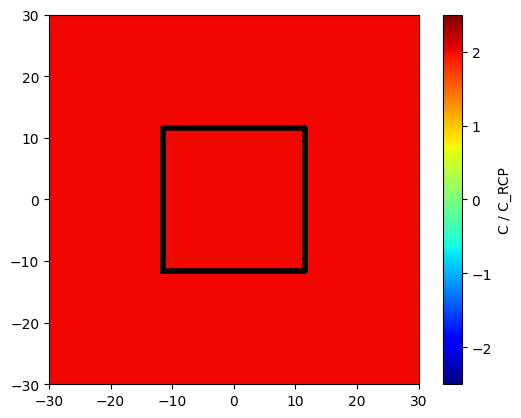

In [15]:
im = visu.scalarfield(C_R, cmap='jet', show=0, interpolation='nearest')

plt.colorbar(im, label='C / C_RCP')
im.set_clim(-2.5, 2.5)
visu.structure_contour(sim, color='k', show=0, lw = 4)
plt.xlim(-30, 30)
plt.ylim(-30, 30)